In [ ]:
import torch
import torch.nn as nn
import torch.optim as optims
import torchvision.datasets.mnist as mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mnist_train = mnist.MNIST("../data",train = True,download = True)

In [ ]:
images = mnist_train.data

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [ ]:
images = images.type(torch.FloatTensor)/255.0

In [ ]:
images = images.view(images.size()[0],-1)

In [ ]:
def kl_divergence(mean, std):
    return torch.sum(-0.5*(1 + std - mean ** 2 - torch.exp(std)))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encode = self._build_model(input_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, hidden_dim)
        self.std = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),nn.ReLU())
        self.s_normal = torch.distributions.normal.Normal(loc = torch.zeros(hidden_dim,), scale = torch.ones(hidden_dim,)) 
        
    def _build_model(self, input_dim, hidden_dim):
        return nn.Sequential(nn.Linear(input_dim, hidden_dim),nn.ReLU(), 
                             nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),
                             nn.Linear(hidden_dim,hidden_dim),nn.ReLU())
        
    def forward(self, input_x):
        encoded_feature = self.encode(input_x)
        mean_feature = self.mean(encoded_feature)
        std_feature = self.std(encoded_feature)
        
        latent_z = self.rsample(mean_feature, std_feature)
        return latent_z, mean_feature, std_feature
    def rsample(self, mean, std):
        #print(mean.size())
        #print(std.size())
        #print(self.s_normal.sample((mean.size()[0],)).size())
        return mean + self.s_normal.sample((mean.size()[0],)).to(torch.device('cuda'))*std

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, input_dim):
        super().__init__()
        self.decode = self._build_model(hidden_dim,input_dim)
        
    def _build_model(self, hidden_dim, input_dim):
        return nn.Sequential(nn.Linear(hidden_dim, hidden_dim),nn.ReLU(), 
                             nn.Linear(hidden_dim,hidden_dim),nn.ReLU(),
                             nn.Linear(hidden_dim, input_dim),nn.Sigmoid())
    def forward(self, latent_z):
        return self.decode(latent_z)


In [ ]:
class VAE():
    def __init__(self, encoder, decoder, introspective = False):
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.introspective = introspective
        
        self.e_optim = optims.Adam(self.encoder.parameters())
        self.d_optim = optims.Adam(self.decoder.parameters())
        
    def train(self, data):
        latent_z, mean, std = self.encoder(data)
        re_data = self.decoder(latent_z)
        
        reconstruction_loss = torch.sum((re_data - data)**2)
        kl_loss = kl_divergence(mean, std)
        if self.introspective:
            re_latent_z, re_mean, re_std = self.encoder(re_data)
        
            d_total_loss = reconstruction_loss + kl_loss + kl_divergence(re_mean, re_std)
            e_total_loss = reconstruction_loss + kl_loss + torch.clamp(torch.ones((1,)).type(torch.FloatTensor).to(torch.device('cuda')) * 10 - kl_divergence(re_mean, re_std), min = 0) 
            self.d_optim.zero_grad()
            d_total_loss.backward(retain_graph = True)
            self.d_optim.step()
        
            self.e_optim.zero_grad()
            e_total_loss.backward()
            self.e_optim.step()
        else:
            total_loss = reconstruction_loss +kl_loss
            
            self.d_optim.zero_grad()
            self.e_optim.zero_grad()
            
            total_loss.backward()
            
            self.d_optim.step()
            self.e_optim.step()
            
        return reconstruction_loss + kl_loss
        

In [ ]:
encoder = Encoder(784,64).to(device)
encoder_ = Encoder(784,64).to(device)

decoder = Decoder(64,784).to(device)
decoder_ = Decoder(64,784).to(device)

In [ ]:
intro_vae = VAE(encoder, decoder, introspective = True)
vae = VAE(encoder_, decoder_)

In [ ]:
epochs = 5000
batch_size = 32

In [ ]:
intro_Loss = []
Loss = []
for epoch in range(epochs):
    batch_index = np.random.choice(images.size()[0],batch_size)
    batch_data = images[batch_index].to(device)
    
    intro_loss = intro_vae.train(batch_data)
    loss = vae.train(batch_data)
    
    intro_Loss.append(intro_loss.detach().cpu().numpy())
    Loss.append(loss.detach().cpu().numpy())
    if epoch %100 == 0:
        print(loss)
        print(intro_loss)

tensor(607.2585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(691.9911, device='cuda:0', grad_fn=<AddBackward0>)
tensor(693.9131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(793.2041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(596.6290, device='cuda:0', grad_fn=<AddBackward0>)
tensor(667.7868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(574.4400, device='cuda:0', grad_fn=<AddBackward0>)
tensor(663.0056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(593.1633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(664.7064, device='cuda:0', grad_fn=<AddBackward0>)
tensor(598.9647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(706.9163, device='cuda:0', grad_fn=<AddBackward0>)
tensor(528.9348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(618.9784, device='cuda:0', grad_fn=<AddBackward0>)
tensor(578.7598, device='cuda:0', grad_fn=<AddBackward0>)
tensor(641.9446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(624.3796, device='cuda:0', grad_fn=<AddBackward0>)
tensor(711.223

In [ ]:
sample_size = 32
s = torch.distributions.normal.Normal(loc = torch.zeros(64,), scale = torch.ones(64,)) 

samples = s.sample((sample_size,)).to(device)

intro_latent,intro_mean, intro_std = encoder(batch_data)
latent, mean, std = encoder_(batch_data)

In [ ]:
intro_output = decoder(samples)
output = decoder_(samples)

In [ ]:
output = output.view(sample_size,28,28)
intro_output = intro_output.view(sample_size,28,28)

In [ ]:
output = output.detach().cpu().numpy()
intro_output = intro_output.detach().cpu().numpy()

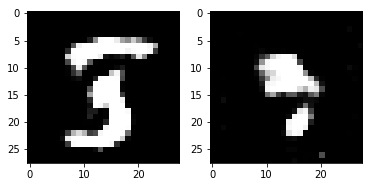

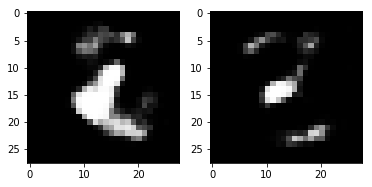

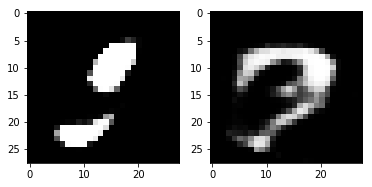

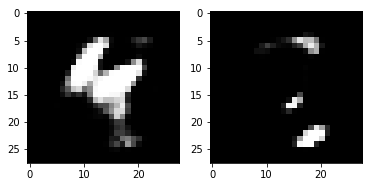

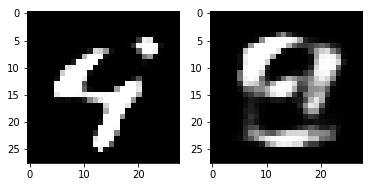

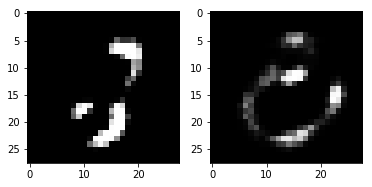

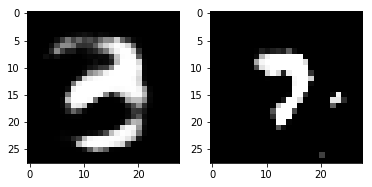

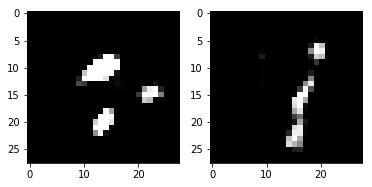

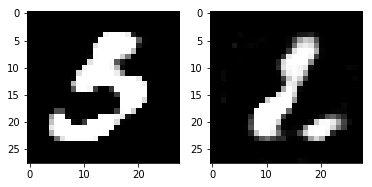

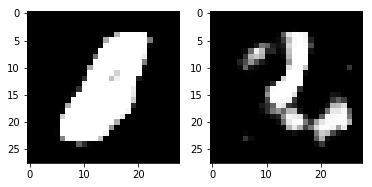

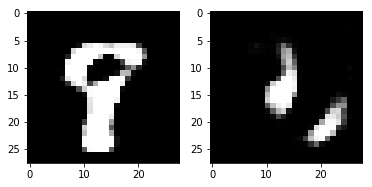

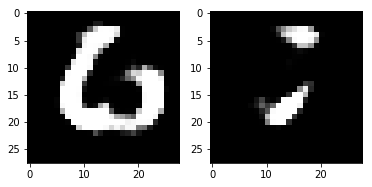

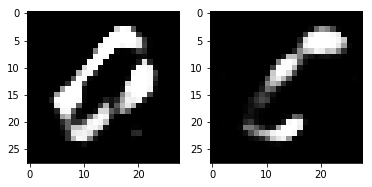

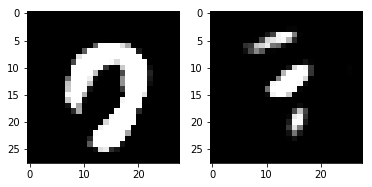

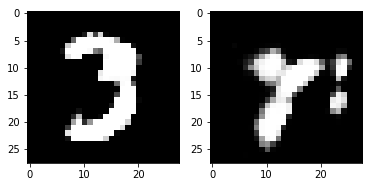

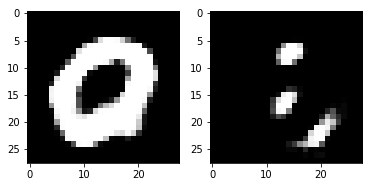

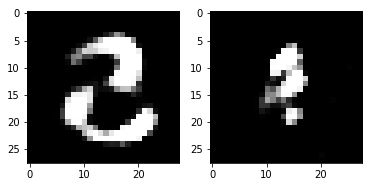

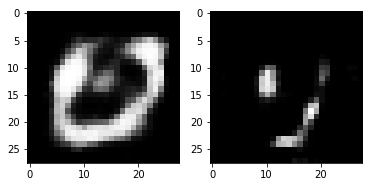

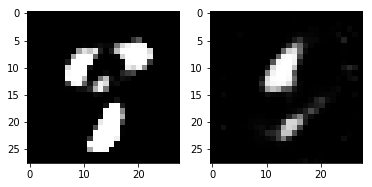

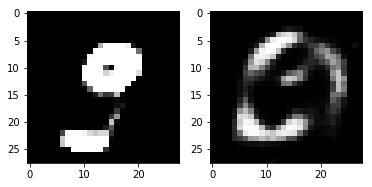

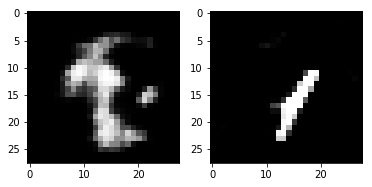

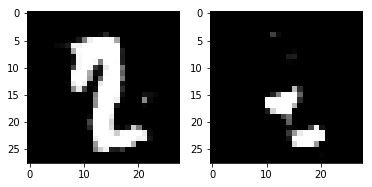

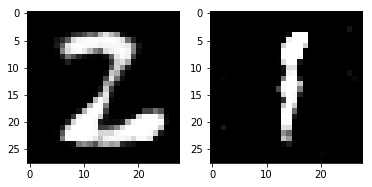

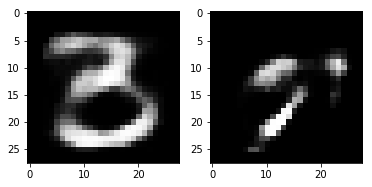

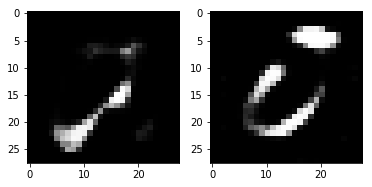

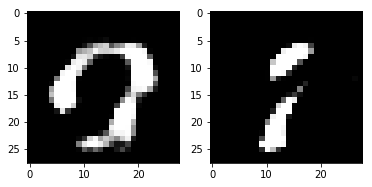

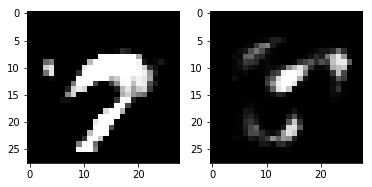

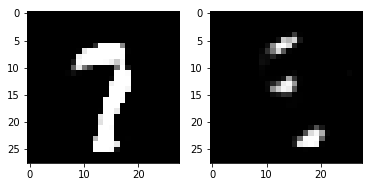

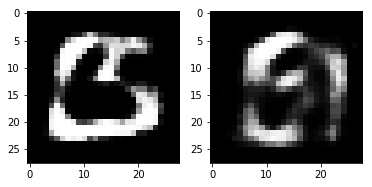

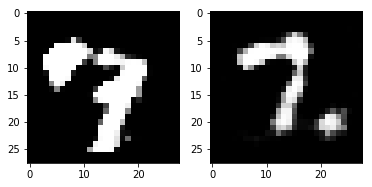

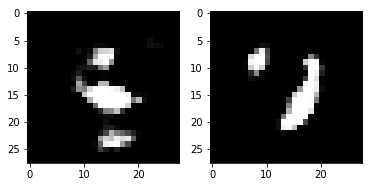

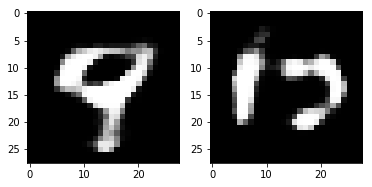

In [ ]:
for i in range(sample_size):
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.imshow(output[i], cmap = 'gray')
    plt.subplot(1,2,2)
    plt.imshow(intro_output[i], cmap = 'gray')
    plt.show()